In [1]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
import math 
import argparse

#https://www.youtube.com/watch?v=U7HRKjlXK-Y


In [2]:
class Vaga:
    def __init__(self, x1, y1, x2, y2 ):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def click_and_crop(event, x, y, flags, param):
    # grab references to the global variables
    global refPt, cropping
 
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being
    # performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        cropping = True
 
    # check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        cropping = False 
        
        v = Vaga(refPt[0][0], refPt[0][1], refPt[1][0], refPt[1][1] )
        vagas.append(v)
        cv2.rectangle(image, refPt[0], refPt[1], (0, 255, 0), 2)
        clone = image.copy()
        #roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
        #cv2.imshow("image", img)
        #cv2.imshow("ROI", roi)

        # draw a rectangle around the region of interest


# Area de Interesse 

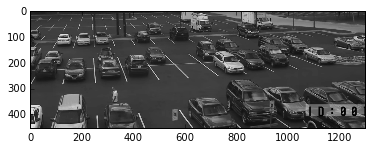

In [3]:
images = [cv2.imread(file, 0) for file in glob.glob("img/3.png")] 
crop_img = images[0][315:900, 0:1300]
plt.imshow(crop_img, cmap='gray')
plt.show()

# Definir Vagas

In [5]:
# initialize the list of reference points and boolean indicating
# whether cropping is being performed or not
refPt = []
vagas = []
cropping = False

# load the image, clone it, and setup the mouse callback function
image = cv2.imread("img/12.png")
 
clone = image.copy()
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)
 
# keep looping until the 'q' key is pressed
while True:
    # display the image and wait for a keypress
    cv2.imshow("image", image)
    key = cv2.waitKey(1) & 0xFF
 
    # if the 'r' key is pressed, reset the cropping region
    if key == ord("r"):
        del refPt[-1]
        image = clone.copy()
 
    # if the 'c' key is pressed, break from the loop
    elif key == ord("c"):
        break
 
# if there are two reference points, then crop the region of interest
# from teh image and display it
if len(refPt) == 2:
    roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
    cv2.imshow("ROI", roi)
    cv2.waitKey(0)
 
# close all open windows
cv2.destroyAllWindows()

In [6]:
len(vagas)

1

 # Processando Video

In [12]:
nomeVideo = "img/ifma.mp4"
videoSaida = "img/output.mp4"
cap = cv2.VideoCapture(nomeVideo)

width =int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height =int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0) #Frame Inicial

while(cap.isOpened()):
    
    video_cur_pos = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0 # Current position of the video file in seconds
    video_cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES) # Index of the frame to be decoded/captured next
    ret, frame = cap.read()  
    
    if ret == False:
        print("Erro de Captura")
        break
        cv2.destroyAllWindows()
        
     # Background Subtraction
    frame_blur = cv2.GaussianBlur(frame.copy(), (5,5), 3)
    frame_gray = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2GRAY)
    frame_out = frame.copy()
    
    
    # Salva the output frame
    if video_cur_frame % 35 == 0: # take every 30 frames
        fourcc = cv2.VideoWriter_fourcc('D','I','V','X')
        out = cv2.VideoWriter(videoSaida, -1, 25, (width, height))
        
    # Display video
    cv2.imshow('Deteccao de Vagas de Estacionamento', frame_out)
    cv2.waitKey(40)
    
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
    elif k == ord('c'):
        cv2.imwrite('img/frame%d.jpg' % video_cur_frame, frame_out)
    elif k == ord('j'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, video_cur_frame+1000) # jump to frame
    
   
    
cap.release()
cv2.destroyAllWindows()    